In [1]:
import torch
print("Using torch", torch.__version__)

Using torch 2.3.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
import cv2

In [4]:
# Load in the optical flow npz data

flows_0 = np.load('/home/armlab/Documents/soft_manipulation/0layer_trials_alldata_avgpoolby6_2_mags.npz')['flow_data']
print(f"Flow data for 0 layers has shape {flows_0.shape}")

flows_1 = np.load('/home/armlab/Documents/soft_manipulation/1layer_trials_alldata_avgpoolby6_2_mags.npz')['flow_data']
print(f"Flow data for 1 layers has shape {flows_1.shape}")

flows_2 = np.load('/home/armlab/Documents/soft_manipulation/2layer_trials_alldata_avgpoolby6_2_mags.npz')['flow_data']
print(f"Flow data for 2 layers has shape {flows_2.shape}")

Flow data for 0 layers has shape (100, 23, 128, 170)
Flow data for 1 layers has shape (100, 23, 128, 170)
Flow data for 2 layers has shape (100, 23, 128, 170)


In [5]:
# Split the data into training and testing
# 75% training, 25% testing
num_trials_0 = flows_0.shape[0]
num_trials_1 = flows_1.shape[0]
num_trials_2 = flows_2.shape[0]

train_0 = flows_0[:int(0.75*num_trials_0)]
test_0 = flows_0[int(0.75*num_trials_0):]
train_1 = flows_1[:int(0.75*num_trials_1)]
test_1 = flows_1[int(0.75*num_trials_1):]
train_2 = flows_2[:int(0.75*num_trials_2)]
test_2 = flows_2[int(0.75*num_trials_2):]

print(f"Training data for 0 layers has shape {train_0.shape}")
print(f"Testing data for 0 layers has shape {test_0.shape}")
print(f"Training data for 1 layers has shape {train_1.shape}")
print(f"Testing data for 1 layers has shape {test_1.shape}")
print(f"Training data for 2 layers has shape {train_2.shape}")
print(f"Testing data for 2 layers has shape {test_2.shape}")

Training data for 0 layers has shape (75, 23, 128, 170)
Testing data for 0 layers has shape (25, 23, 128, 170)
Training data for 1 layers has shape (75, 23, 128, 170)
Testing data for 1 layers has shape (25, 23, 128, 170)
Training data for 2 layers has shape (75, 23, 128, 170)
Testing data for 2 layers has shape (25, 23, 128, 170)


In [6]:
train_data = np.concatenate((train_0, train_1, train_2), axis=0)
train_data_tensor = torch.tensor(train_data).float().to(device)
# train_data_tensor = train_data_tensor.reshape(225, 2*23, 128, 170)

labels_train = np.empty((train_data.shape[0]))
labels_train[:train_0.shape[0]] = 0
labels_train[train_0.shape[0]:train_0.shape[0]+train_1.shape[0]] = 1
labels_train[train_0.shape[0]+train_1.shape[0]:] = 2
labels_train = torch.tensor(labels_train, dtype=torch.long).to(device)
print(f"Train Labels Shape: {labels_train.shape}")

Train Labels Shape: torch.Size([225])


In [7]:
labels_test = np.empty((test_1.shape[0] + test_0.shape[0] + test_2.shape[0]))
labels_test[0:25] = 0
labels_test[25:50] = 1
labels_test[50:75] = 2
labels_test = torch.tensor(labels_test, dtype=torch.long).to(device)
print(f"Train Labels Shape: {labels_test.shape}")

test_data = np.concatenate((test_0, test_1, test_2), axis=0)
test_data_tensor = torch.tensor(test_data).float().to(device)
# test_data_tensor = test_data_tensor.reshape(75, 23, 128, 170)
print(labels_test)

Train Labels Shape: torch.Size([75])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2], device='cuda:0')


In [8]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_data_tensor, labels_train)
test_dataset = TensorDataset(test_data_tensor, labels_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [9]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_size):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(23, 16, kernel_size=3, stride=2, padding=(1, 2))  # (N, 16, 64, 85)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=(1, 2))  # (N, 32, 32, 43)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # (N, 64, 16, 22)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # (N, 128, 8, 11)
        self.fc1 = nn.Linear(128 * 8 * 11, 512)  # Latent vector size = 512
        self.fc2 = nn.Linear(512, 128)  # Output size = 256
        self.fc3 = nn.Linear(128, output_size)  # Output size = 256
        # self.fc2 = nn.Linear(output_size, 3)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten
        z = self.fc1(x) # Latent vector is dim 512
        x = self.fc2(z)
        x = self.fc3(x)
        return x, z

# Initialize the model, loss function, and optimizer
model = CNNFeatureExtractor(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 150
loss_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, z = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping
        optimizer.step()
        running_loss += loss.item()
    # Condition to reset the optimizer state (e.g., halfway through training)
    if epoch == num_epochs // 2:
        # Save the model state
        model_state = model.state_dict()
        
        # Reinitialize the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        
        # Load the model state back
        model.load_state_dict(model_state)

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

print('Finished Training')

Epoch 1, Loss: 0.9032170983171282
Epoch 2, Loss: 0.7748158262048467
Epoch 3, Loss: 0.7852337821138293
Epoch 4, Loss: 0.731818890722419
Epoch 5, Loss: 0.7215333285525113
Epoch 6, Loss: 0.7446711575365695
Epoch 7, Loss: 0.8530014225915077
Epoch 8, Loss: 0.6327976863768063
Epoch 9, Loss: 0.6234239576184266
Epoch 10, Loss: 0.5779850012692183
Epoch 11, Loss: 0.6341572321695957
Epoch 12, Loss: 0.5051411181408023
Epoch 13, Loss: 0.30423868089731776
Epoch 14, Loss: 0.24231385868257344
Epoch 15, Loss: 0.23553469206651462
Epoch 16, Loss: 0.24385440736267863
Epoch 17, Loss: 0.14909472244202002
Epoch 18, Loss: 0.17681959173247414
Epoch 19, Loss: 0.13947229018492777
Epoch 20, Loss: 0.044915739250576694
Epoch 21, Loss: 0.07451880002583808
Epoch 22, Loss: 0.030908417313864723
Epoch 23, Loss: 0.0022891414273426267
Epoch 24, Loss: 0.0077297655754853395
Epoch 25, Loss: 8.001800163280333e-05
Epoch 26, Loss: 1.2832620998660052e-05
Epoch 27, Loss: 8.387261716910743e-06
Epoch 28, Loss: 7.556604190965703e-06

In [12]:
# Evaluation loop with predictions and confidence
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

Accuracy of the network on the 75 test images: 61.333333333333336%


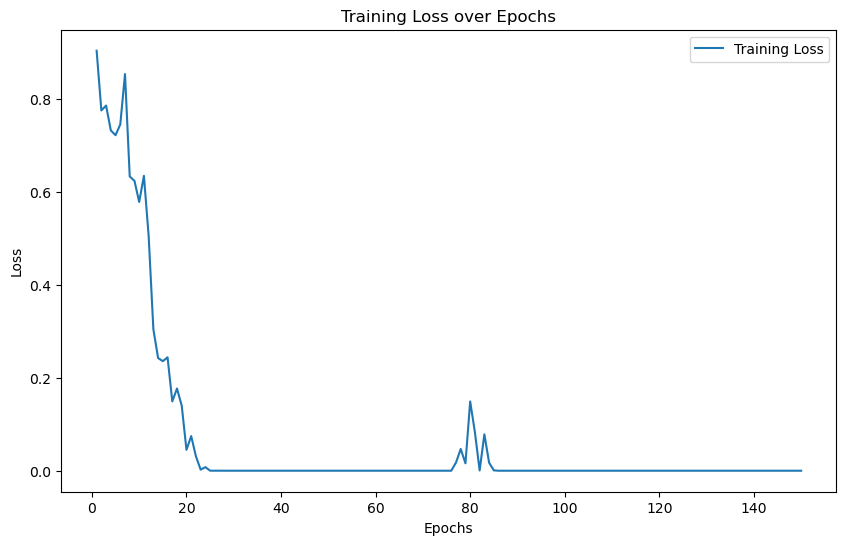

In [13]:
# Plot the loss values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Features shape before t-SNE: (75, 512)
Labels shape: (75,)
Features shape after t-SNE: (75, 2)


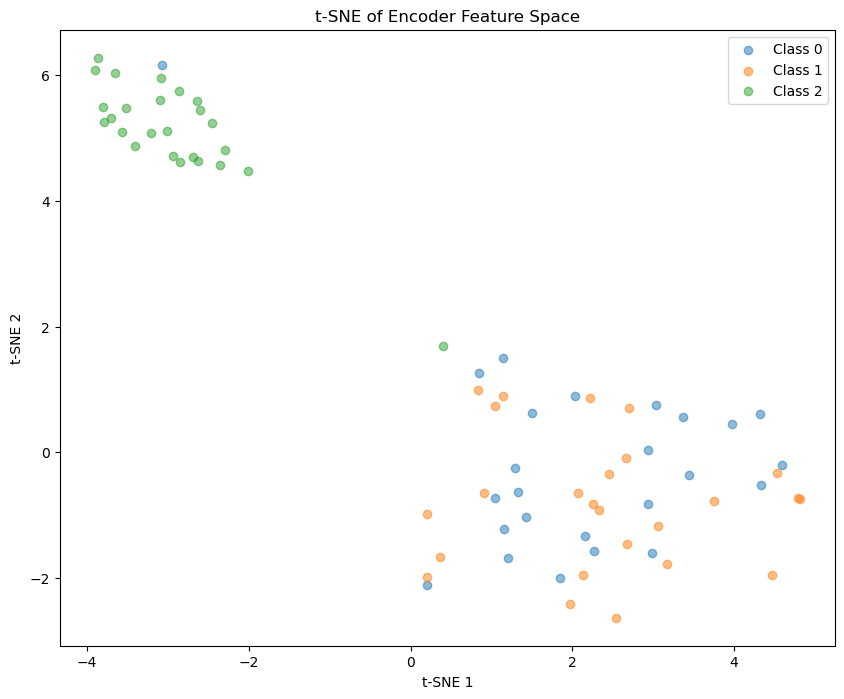

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Ensure the model is in evaluation mode
model.eval()

# Extract feature vectors and labels for the test set
features = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device
        _, z = model(inputs)  # Extract the latent vector `z`
        features.append(z)
        labels_list.append(labels)

# Convert lists to tensors
features = torch.cat(features, dim=0).to('cpu').detach().numpy()
labels_list = torch.cat(labels_list, dim=0).to('cpu').numpy()

# Check the shapes
print(f"Features shape before t-SNE: {features.shape}")
print(f"Labels shape: {labels_list.shape}")

# Ensure that the shapes match
assert features.shape[0] == labels_list.shape[0], "Features and labels must have the same number of samples"

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Check the shape after t-SNE
print(f"Features shape after t-SNE: {features_2d.shape}")

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
for label in np.unique(labels_list):
    idx = labels_list == label
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f'Class {label}', alpha=0.5)
plt.legend()
plt.title('t-SNE of Encoder Feature Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
